# Demo: beat finding paradigm

**Authors:   Manuel Anglada-Tort, Peter Harrison, Nori Jacoby**

This demo shows how to apply _REPP_ in beat finding paradigms using finger tapping experiments. 


In [17]:
# Before starting, set the right working dir and imports
import os
if 'path_to_dir' not in globals():
    path_to_dir = os.path.split(os.getcwd())[0]
os.chdir(path_to_dir)

# working directories for input and output files
input_dir = "music"
output_dir = "notebook/output"

# name stimulus
# WAV_FILE = "music/0R8IbpKXavM.wav"
WAV_FILE = "music/silence_5sec.wav" # or change for 10 sec (silence_10sec.wav)

import matplotlib
import matplotlib.image as mpimg
from matplotlib import pyplot as plt
# For Jupyter notebooks, use inline backend (no need to set GUI backend)
%matplotlib inline

# Finally, import REPP configuration for SMS experiments
# Load experiment parameters from config file
from repp.config import sms_tapping


# Define filenames for outputs
filenames = {
    'stim_info_file': 'stim_info.json',
    'audio_filename': 'stim_audio.wav',
    'recording_filename': 'recording.wav',
    'plot_filename': 'beat_finding_plot.png',
    'title_plot': 'Beat Finding Analysis'
}




## 1 Stimulus preparation
We can now start with the first step: preparing the audio stimulus to be used with _REPP_

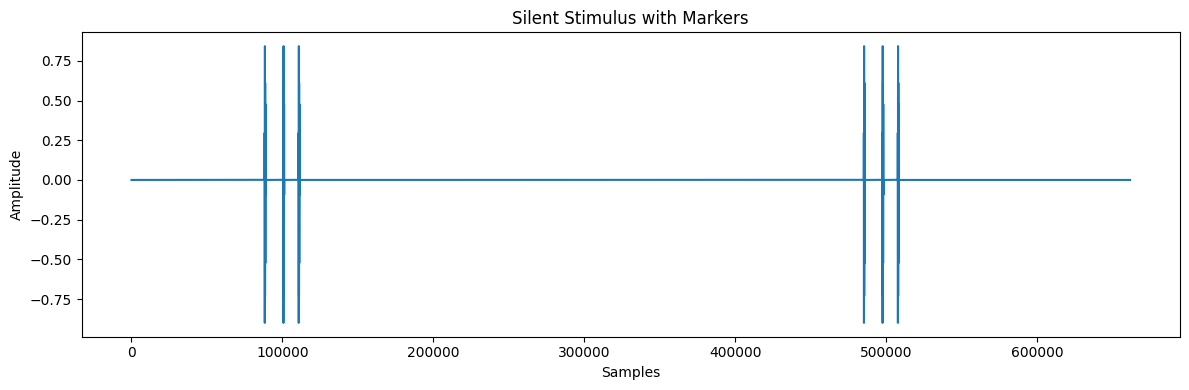

In [19]:
from repp.stimulus import REPPStimulus
import json
import numpy as np

stimulus = REPPStimulus("temp", config=sms_tapping)

class NumpySerializer(json.JSONEncoder):
    def default(self, obj):
        import numpy as np

        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        elif isinstance(obj, np.bool_):
            return super().encode(bool(obj))
        else:
            return super().default(obj)

# Define helper functions for creating music stimulus (avoid importing experiment.py which has PsyNet dependencies)
def load_audio_only_from_file(fs, audio_filename):
    """
    Load audio file without requiring onsets file.
    """
    stimulus = REPPStimulus("temp", config=sms_tapping)
    return stimulus.load_resample_file(fs, audio_filename)

def filter_and_add_markers_no_onsets(stim, config):
    """
    Apply filtering and add markers without requiring onset information.
    """
    stimulus = REPPStimulus("temp", config=config)
    
    # --- NEW: handle silent input ---------------------------------
    import numpy as np
    # If the signal is (almost) silent, skip filter_stim entirely
    if np.max(np.abs(stim)) < 1e-8:
        # keep it silent; we only want the markers
        filtered_stim = np.zeros_like(stim, dtype=float)
    else:
        # Apply spectral filtering as usual
        filtered_stim = stimulus.filter_stim(
            config.FS, stim, config.STIM_RANGE, config.STIM_AMPLITUDE
        )

        # Guard against NaNs/Infs just in case
        filtered_stim = np.nan_to_num(filtered_stim, nan=0.0, posinf=0.0, neginf=0.0)
    # ----------------------------------------------------------------

    
    # Create marker sounds
    markers_sound = stimulus.make_markers_sound(
        config.FS,
        config.MARKERS_DURATION,
        config.MARKERS_ATTACK,
        config.MARKERS_RANGE,
        config.MARKERS_AMPLITUDE
    )
    
    # Add markers at beginning and end
    markers_onsets, markers_channel = stimulus.add_markers_sound(
        config.FS,
        stim,
        config.MARKERS_IOI,
        config.MARKERS_BEGINNING,
        config.MARKERS_END,
        config.STIM_BEGINNING,
        config.MARKERS_END_SLACK
    )
    
    # Combine markers with filtered stimulus
    stim_prepared = stimulus.put_clicks_in_audio(markers_channel, config.FS, markers_sound, markers_onsets)
    stim_start_samples = int(round(config.STIM_BEGINNING * config.FS / 1000.0))
    stim_prepared[stim_start_samples:(stim_start_samples + len(filtered_stim))] += filtered_stim
    
    stim_duration = len(stim_prepared) / config.FS
    
    # Create minimal stim_info for beat-finding task
    stim_info = {
        'stim_duration': stim_duration,
        'stim_onsets': [],  # Empty for beat-finding
        'stim_shifted_onsets': [],  # Empty for beat-finding
        'onset_is_played': np.array([]),  # Empty for beat-finding
        'markers_onsets': markers_onsets,
        'stim_name': 'beat_finding_music'
    }
    
    return stim_prepared, stim_info

def create_music_stim_with_repp_beat_finding(stim_name, audio_filename, fs=44100):
    """
    Create music stimulus without requiring onsets file.
    """
    # Load audio file
    stim = load_audio_only_from_file(fs, audio_filename)
    
    # Convert stereo to mono if needed
    if len(stim.shape) == 2:
        stim = stim[:, 0]
    
    # Apply filtering and add markers
    stim_prepared, stim_info = filter_and_add_markers_no_onsets(stim, sms_tapping)
    stim_info["stim_name"] = stim_name
    
    info = json.dumps(stim_info, cls=NumpySerializer)
    return stim_prepared, info


# Create the stimulus for music beat finding
stim_prepared, stim_info_json = create_music_stim_with_repp_beat_finding(
    "silent_stim",
    WAV_FILE
)
stim_info = json.loads(stim_info_json)


# Plot
plt.figure(figsize=(12, 4))
plt.plot(stim_prepared)
plt.title('Silent Stimulus with Markers')
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.tight_layout()
plt.show()

# save stimulus info
REPPStimulus.to_json(
    stim_info,
    os.path.join(output_dir,filenames['stim_info_file'])
)

# save audio stimulus
REPPStimulus.to_wav(
    stim_prepared,
    os.path.join(output_dir,filenames['audio_filename']),
    sms_tapping.FS
)

## 2 Recording phase
**Instructions:**

    - Only use the laptop speakers (unplug headphones or wireless devices)
    - Turn on your volume
    - Tap on the surface of your laptop with your index finger (do not tap on any key or trackpad)

In [20]:
import sounddevice as sd

print("****RECORDING PHASE: Please tap in time to the music")

myrecording = sd.playrec(stim_prepared, stimulus.config.FS, channels=1)
sd.wait()  # Wait until recording is finished

# save recording to wav
REPPStimulus.to_wav(
    myrecording,
    os.path.join(output_dir,filenames['recording_filename']),
    stimulus.config.FS
)

****RECORDING PHASE: Please tap in time to the music


## 3 Analysis: signal processing and performance analysis

In [21]:
# Beat Finding Analysis

from repp_beatfinding.beat_detection import (
    do_beat_detection_analysis,
)

output, extracted_onsets, stats = do_beat_detection_analysis(
    os.path.join(output_dir, filenames['recording_filename']),
    filenames['title_plot'],
    os.path.join(output_dir, filenames['plot_filename']),
    stim_info=stim_info
)


Preparing marker onsets...
Extracting audio signals from mono recording...
reading audio file:
fs=44100 len(samples)=661500
Extracting raw onsets from audio signals...
Aligning onsets...
Tapping analysis...
Analysing results...
Creating plot: Beat Finding Analysis
Data extracted - Time points: 330000, Taps: 7, Markers: 6, IOIs: 6
Plot saved


<Figure size 640x480 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

In [22]:
print(extracted_onsets)

{'num_markers_onsets': 6, 'num_markers_detected': np.int64(6), 'num_markers_missed': np.int64(0), 'markers_max_difference': np.float64(0.6818181818184902), 'markers_status': 'Good', 'markers_ok': True, 'num_resp_raw_all': 7.0, 'num_resp_aligned_all': 7, 'num_taps_detected': 7, 'tapping_onsets_aligned': array([3722.72727273, 4289.31818182, 4577.72727273, 5238.40909091,
       5567.72727273, 6205.90909091, 6574.09090909]), 'tapping_onsets_detected': array([5850.        , 6416.59090909, 6705.        , 7365.68181818,
       7695.        , 8333.18181818, 8701.36363636]), 'tapping_iois': array([566.59090909, 288.40909091, 660.68181818, 329.31818182,
       638.18181818, 368.18181818]), 'tapping_mean_ioi': np.float64(475.2272727272726), 'tapping_sd_ioi': np.float64(151.07620128611046), 'tapping_median_ioi': np.float64(467.38636363636374), 'tapping_cv_ioi': np.float64(31.79030538779944), 'tapping_min_ioi': np.float64(288.4090909090901), 'tapping_max_ioi': np.float64(660.681818181818), 'tapping

(np.float64(-0.5), np.float64(5399.5), np.float64(2999.5), np.float64(-0.5))

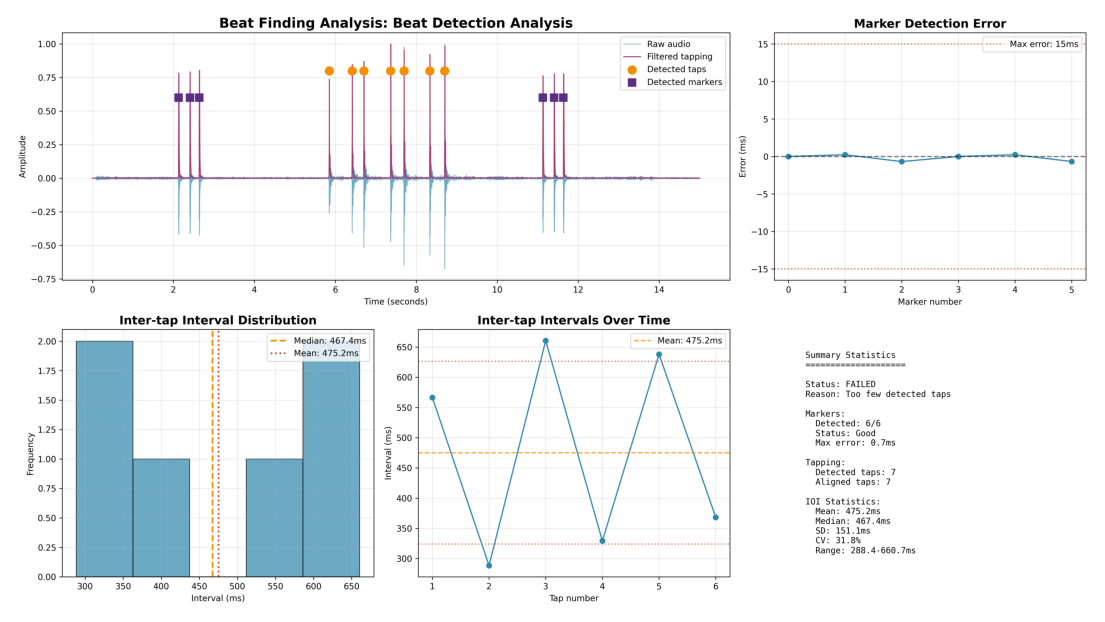

In [23]:
# and show the plot here
plt.figure(figsize=(14, 12))  # Adjust these numbers as needed
img = mpimg.imread(os.path.join(output_dir, filenames['plot_filename']))
imgplot = plt.imshow(img)
plt.axis('off')